# Understanding self-attention

In [60]:
import torch
import torch.nn.functional as F

torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

tril = torch.tril(torch.ones(T, T))
w = torch.zeros(T, T)
w = w.masked_fill(tril==0, float('-inf'))
w = F.softmax(w, dim=-1)
out = w@x
# print("w\n", w)
# print("x\n", x)
# print("out\n", out)

print("################################self attention################################")
import torch.nn as nn
#implementing a single head to perform self-attention

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, head_size)
q = query(x) # (B, T, head_size)
print("k\n", k.shape)
print("k.transpose(-2,-1)\n", k.transpose(-2,-1).shape)
print("q\n", q.shape)
w = q@k.transpose(-2,-1)#transposing the last two dimensions
tril = torch.tril(torch.ones(T, T))
w = w.masked_fill(tril==0, float('-inf'))
w = F.softmax(w, dim=-1)
v = value(x)
out = w@v
print("w\n", w.shape)
print("x\n", x.shape)
print("out\n", out.shape)

################################self attention################################
k
 torch.Size([4, 8, 16])
k.transpose(-2,-1)
 torch.Size([4, 16, 8])
q
 torch.Size([4, 8, 16])
w
 torch.Size([4, 8, 8])
x
 torch.Size([4, 8, 32])
out
 torch.Size([4, 8, 16])


# Implementing

In [61]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

In [62]:
#preparing the input data to the gpt model
data_file = "tiny_shakespeare.txt"
input_file = open(data_file, 'r')
input_text = input_file.read()
print(input_text[:100])
#getting all the characters of the dataset
chars = sorted(list(set(input_text)))
vocab_size = len(chars)
print(f"{len(chars)} characters in dataset")
print(chars)

#creating mapping from character to int and vice versa
char2int = {c:i for i,c in enumerate(chars)}
int2char = {i:c for i,c in enumerate(chars)}
encoder = lambda s: [char2int[c] for c in s]
decoder = lambda l: ''.join([int2char[i] for i in l])

print(f"encoded: {encoder('hello')}")
print(f"decoded: {decoder(encoder('hello'))}")
#coding the text dataset and storing it as a pytorch tensor
data_tensor = torch.tensor(encoder(input_text), dtype=torch.long)
print(data_tensor.shape, data_tensor.dtype)
print(data_tensor[:100])


#splitting the dataset into training and validation sets
train_size = 0.9
train_data = data_tensor[:int(train_size*len(data_tensor))]
val_data = data_tensor[int(train_size*len(data_tensor)):]
print("Training data shape", train_data.shape)
print("Validation data shape", val_data.shape)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
65 characters in dataset
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
encoded: [46, 43, 50, 50, 53]
decoded: hello
torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
Training data shape

In [63]:
import matplotlib.pyplot as plt
from tqdm import tqdm
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            losses[i] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_batch(split="train"):
    #getting a random batch from the test data or the validation data
    data = train_data if split == "train" else val_data
    #making sure we are staying within the length of the data
    idxs = torch.randint(len(data)-block_size, (batch_size,))
    #getting the x and y values for the batch
    xs = [data[idx:idx+block_size] for idx in idxs]
    ys = [data[idx+1:idx+block_size+1] for idx in idxs]
    #concatenating the tesnors and returning as a single tensor
    return torch.stack(xs).to(device), torch.stack(ys).to(device)

def train_model(epochs=3000):
    losses = []
    for steps in tqdm(range(epochs)):
    
        #getting the batch
        xb, yb = get_batch("train")
        #evaluating the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        # estimated_loss = estimate_loss()
        losses.append(loss.item())
    plt.plot(losses)
    plt.show()

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)

class Head(nn.Module):
    """One head of self attention"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # computing the self attention scores
        w = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, T) and dividing by sqrt(C)
        w = w.masked_fill(self.tril[:T,:T]==0, float('-inf')) # B, T, T
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        v = self.value(x) # (B, T, head_size)
        out = w @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out
    
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd//n_head
        self.sa_heads = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa_heads(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTmodel(nn.Module):
    
    def __init__(self):
        super(GPTmodel, self).__init__()
        self.token_embeddings_table = nn.Embedding(vocab_size, n_embd)
        self.position_embeddings_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)


    def forward(self, idx, targets=None):
        B, T = idx.shape
        #idx and targets are both (B, T) shape tensors
        token_embeddings = self.token_embeddings_table(idx) #(B, T, n_embd)
        pos_embeddings = self.position_embeddings_table(torch.arange(T).to(device)) #(T, n_embd)
        x = token_embeddings + pos_embeddings #(B, T, n_embd)
        x = self.sa_heads(x) #(B, T, n_embd)
        x = self.blocks(x) #(B, T, n_embd)
        x = self.ln_f(x) #(B, T, n_embd)
        logits = self.lm_head(x) #(B, T, vocab_size)
        
        if targets==None:
            loss = None
        else:        
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        #idx is a (B, T) shape array
        for _ in range(max_new_tokens):
            #we can not accomodate more than block_size tokens
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            #we are only interested in the last token of the sequence
            #B, C  = logits.shape
            logits = logits[:, -1, :]
            #apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            idx = torch.cat([idx, idx_next], dim=1) #(B, T+1)
        return idx

100%|██████████| 30000/30000 [2:14:52<00:00,  3.71it/s]  


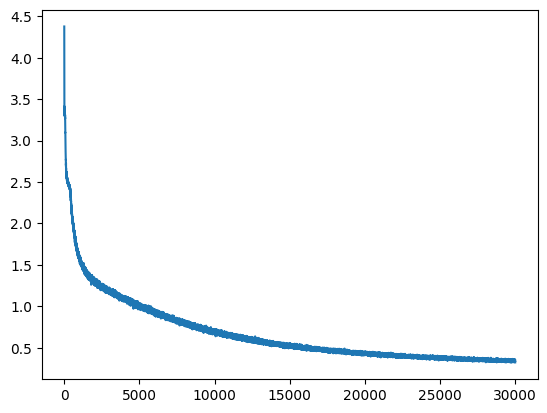

In [65]:
model = GPTmodel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_model(30000)

In [66]:
idx = torch.zeros((1,1), dtype=torch.long).to(device)
print(decoder(model.generate(idx, 1000)[0].tolist()))


Flower in despite need a corse.

DUKE OF YORK:
O Maulius wrethe hited at Margaret!

DUKE VINCENTIO:
I know you for Claudio.
Do you persuad that I resumble now
That 'tis no hope of your honour might be 'em,
For your queen as we have beth a king,
To victary your hearing and well-swearing gloves,
Look to beat by the spiltre of a small joy
And keep the nunkatural, to reign:
And lie thee again,--I will verse coal thee,
That make present to thy master and come
As I did incense thee to pursue thyself.

WARWICK:
Why, then, fare-neasted Warwick, do not thyself.
Methinks Edward and Somerset both be:
Ahorse, thy father, and thy father brand;
And yet thy fright father rich fan
A mersel of the envious tax banishment.

HASTINGS:
Thine ear thus my Henry to the state,
That my father remove send my hands that bears them.

EXETER:
Richard, and hear my king.

YORK:
Ay, marry, you soldier, there shall be the deed.

HENRY BOLINGBROKE:
Be it is most safe of noble in grief,
Let him be some third with this o